In [19]:
import os
import cv2
import dlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [7]:
# Load dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Ensure you have this file

def plot_landmark(image_folder):
    image_files = os.listdir(image_folder)

    # Select an image to visualize
    image_path = os.path.join(image_folder, image_files[0])
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    if len(faces) == 0:
        print("No face detected.")
        return

    # Create a blank white image for landmark visualization
    h, w = gray.shape
    blank_image = np.ones((h, w, 3), dtype=np.uint8) * 255  # White background

    for face in faces:
        landmarks = predictor(gray, face)

        for idx in range(68):  # 68 facial landmarks
            x, y = landmarks.part(idx).x, landmarks.part(idx).y
            cv2.circle(image, (x, y), 1, (0, 255, 0), -1)  # Green dots on landmarks
            cv2.circle(blank_image, (x, y), 2, (0, 0, 255), -1)  # Red dots on blank image
            
            # Label some key landmarks
            if idx % 5 == 0:
                cv2.putText(blank_image, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)

    # Convert to RGB for visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blank_rgb = cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB)

    # Show both images
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_rgb)
    axs[0].axis("off")
    axs[0].set_title(f"Face Landmark Map")

    axs[1].imshow(blank_rgb)
    axs[1].axis("off")
    axs[1].set_title(f"Blank Landmark Map with indices")

    plt.show()


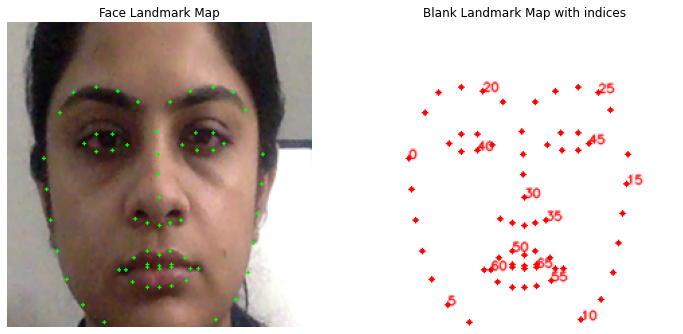

In [8]:
plot_landmark("Drowsy")

In [15]:
# Initialize dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Provide the correct path

# Define landmark indices
LEFT_EYE = [36, 37, 38, 39, 40, 41]
RIGHT_EYE = [42, 43, 44, 45, 46, 47]
MOUTH = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]

# Define extreme points (corner points)
EXTREME_POINTS = {
    "LEFT_EYE": [LEFT_EYE[0], LEFT_EYE[3]],  # Outer and inner corner
    "RIGHT_EYE": [RIGHT_EYE[0], RIGHT_EYE[3]],  # Outer and inner corner
    "MOUTH": [MOUTH[0], MOUTH[6], MOUTH[3], MOUTH[9]]  # Outer left, outer right, top, bottom
}

def plot_eye_mouth_landmark_dlib(image_folder):
    image_files = os.listdir(image_folder)

    # Select an image to process
    image_path = os.path.join(image_folder, image_files[0])
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    if faces:
        for face in faces:
            landmarks = predictor(gray, face)

            h, w, _ = image.shape

            # Create a blank white background for labeled landmarks
            blank_image = 255 * np.ones((h, w, 3), dtype=np.uint8)

            # Process all points (draw landmarks on the image)
            for idx in LEFT_EYE + RIGHT_EYE + MOUTH:
                x, y = landmarks.part(idx).x, landmarks.part(idx).y

                # Define colors
                color = (0, 255, 0) if idx in LEFT_EYE else (0, 0, 255) if idx in RIGHT_EYE else (255, 0, 0)

                # Draw landmarks on the original image
                cv2.circle(image, (x, y), 2, color, -1)

                # Draw landmarks on the white background
                cv2.circle(blank_image, (x, y), 2, color, -1)
                cv2.putText(blank_image, str(idx), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                            0.2, (0, 0, 0), 1, cv2.LINE_AA)

            # Convert to RGB for visualization
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            blank_rgb = cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB)

            # Show the original image with landmarks
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.axis("off")
            plt.title("Eye and Mouth Landmarks (Original Image)")

            # Show the labeled landmark positions on the blank background
            plt.subplot(1, 2, 2)
            plt.imshow(blank_rgb)
            plt.axis("off")
            plt.title("Labeled Landmarks on Blank Background")

            plt.show()

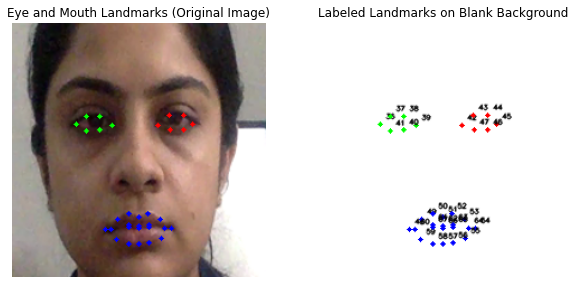

In [16]:
plot_eye_mouth_landmark_dlib("Drowsy")

In [17]:
# EAR Calculation Function
def calculate_ear(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

# MAR Calculation Function
def calculate_mar(mouth):
    A = np.linalg.norm(mouth[1] - mouth[7])  # Vertical distances
    B = np.linalg.norm(mouth[2] - mouth[6])
    C = np.linalg.norm(mouth[0] - mouth[4])  # Horizontal distance
    return (A + B) / (2.0 * C)

# Head Pose Estimation Function
def estimate_head_pose(landmarks):
    left_eye = landmarks[LEFT_EYE[0]]   # Outer corner of left eye
    right_eye = landmarks[RIGHT_EYE[3]] # Outer corner of right eye
    nose = landmarks[30]  # Nose tip (key reference point)

    dx = right_eye[0] - left_eye[0]
    dy = right_eye[1] - left_eye[1]

    head_tilt_angle = np.arctan2(dy, dx) * (180.0 / np.pi)  # Convert to degrees
    return head_tilt_angle

# Process Images from Folder and Extract Features
def extract_features_dlib(folder_name, label):
    data = []
    for img_name in tqdm(os.listdir(folder_name), desc=f"Processing {label} images"):
        img_path = os.path.join(folder_name, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue  # Skip if image is not found or unreadable

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        if len(faces) == 0:
            continue  # Skip if no face is detected

        for face in faces:
            landmarks = predictor(gray, face)
            landmarks_np = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

            # Compute EAR, MAR, and Head Pose
            ear_left = calculate_ear(landmarks_np[LEFT_EYE])
            ear_right = calculate_ear(landmarks_np[RIGHT_EYE])
            ear_avg = (ear_left + ear_right) / 2.0

            mar = calculate_mar(landmarks_np[MOUTH])

            head_pose = estimate_head_pose(landmarks_np)

            data.append([img_path, ear_avg, mar, head_pose, label])

    return pd.DataFrame(data, columns=["image_path", "EAR", "MAR", "Head_Pose", "Label"])

# Extract features for drowsy and non-drowsy images
df_drowsy = extract_features_dlib("Drowsy", "Drowsy")
df_non_drowsy = extract_features_dlib("Non Drowsy", "Non Drowsy")

# Combine and save the dataset
df = pd.concat([df_drowsy, df_non_drowsy], ignore_index=True)
df.to_csv("drowsiness_features_dlib.csv", index=False)

print("Feature extraction completed! CSV saved.")

Processing Non Drowsy images: 100%|████████████████████████████████████████████████████████████████████████████████████| 19445/19445 [02:01<00:00, 159.68it/s]


Feature extraction completed! CSV saved.


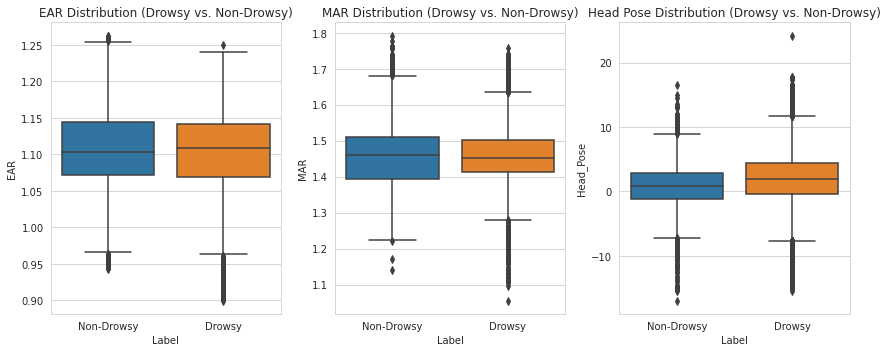

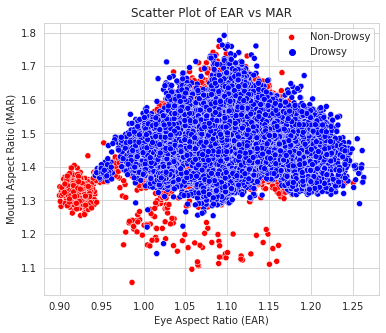

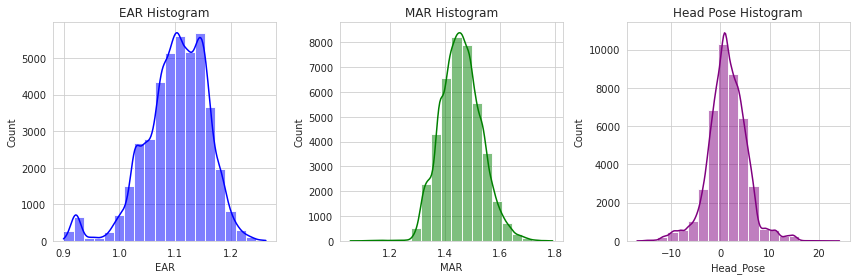

In [20]:
# Load extracted feature dataset
df = pd.read_csv("drowsiness_features.csv")

# Set theme
sns.set_style("whitegrid")

# Convert categorical labels to numerical values (for better visualization)
df['Label'] = df['Label'].map({'Drowsy': 1, 'Non Drowsy': 0})

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x=df["Label"], y=df["EAR"])
plt.title("EAR Distribution (Drowsy vs. Non-Drowsy)")
plt.xticks([0, 1], ["Non-Drowsy", "Drowsy"])

plt.subplot(1, 3, 2)
sns.boxplot(x=df["Label"], y=df["MAR"])
plt.title("MAR Distribution (Drowsy vs. Non-Drowsy)")
plt.xticks([0, 1], ["Non-Drowsy", "Drowsy"])

plt.subplot(1, 3, 3)
sns.boxplot(x=df["Label"], y=df["Head_Pose"])
plt.title("Head Pose Distribution (Drowsy vs. Non-Drowsy)")
plt.xticks([0, 1], ["Non-Drowsy", "Drowsy"])
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 5))
sns.scatterplot(x=df["EAR"], y=df["MAR"], hue=df["Label"], palette=["blue", "red"])
plt.title("Scatter Plot of EAR vs MAR")
plt.xlabel("Eye Aspect Ratio (EAR)")
plt.ylabel("Mouth Aspect Ratio (MAR)")
plt.legend(["Non-Drowsy", "Drowsy"])
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df["EAR"], bins=20, kde=True, color="blue")
plt.title("EAR Histogram")

plt.subplot(1, 3, 2)
sns.histplot(df["MAR"], bins=20, kde=True, color="green")
plt.title("MAR Histogram")

plt.subplot(1, 3, 3)
sns.histplot(df["Head_Pose"], bins=20, kde=True, color="purple")
plt.title("Head Pose Histogram")

plt.tight_layout()
plt.show()


In [21]:
# Load dataset
df = pd.read_csv("drowsiness_features.csv")

# Encode labels (Drowsy -> 1, Non Drowsy -> 0)
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])

# Extract features and labels
X = df[["EAR", "MAR", "Head_Pose"]].values
y = df["Label"].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN + LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # 1 timestep since we only have single feature vectors

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split into Train (80%) and Validation (20%) - No Test Split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

print(f"Training Size: {X_train.shape[0]}, Validation Size: {X_val.shape[0]}")


Training Size: 33420, Validation Size: 8356


In [26]:
class DrowsinessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Datasets
train_dataset = DrowsinessDataset(X_train, y_train)
val_dataset = DrowsinessDataset(X_val, y_val)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


In [27]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        
        # 1D CNN Layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=16, hidden_size=32, num_layers=1, batch_first=True)
        
        # Fully Connected Layer
        self.fc = nn.Linear(32, 2)  # 2 classes (Drowsy / Non-Drowsy)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Reshape for LSTM (batch_size, sequence_length, input_size)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)

        # Take the output of the last LSTM timestep
        x = x[:, -1, :]

        x = self.fc(x)
        return x

# Initialize Model
model = CNN_LSTM()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
import time
import matplotlib.pyplot as plt

# Early Stopping Parameters
patience = 5
best_val_loss = float("inf")
counter = 0

# Store Loss & Accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training Loop
num_epochs = 50

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training Phase
    model.train()
    train_loss, train_correct = 0.0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    # Store Training Loss & Accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    # Store Validation Loss & Accuracy
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print Epoch Results
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {time.time() - start_time:.2f}s")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break
            
torch.save(model, "best_model_full.pth")
print("Training complete.")

Epoch [1/50] | Train Loss: 0.5797 | Train Acc: 0.6718 | Val Loss: 0.5072 | Val Acc: 0.7373 | Time: 6.56s
Epoch [2/50] | Train Loss: 0.5085 | Train Acc: 0.7353 | Val Loss: 0.4708 | Val Acc: 0.7590 | Time: 6.58s
Epoch [3/50] | Train Loss: 0.4813 | Train Acc: 0.7574 | Val Loss: 0.4498 | Val Acc: 0.7762 | Time: 6.66s
Epoch [4/50] | Train Loss: 0.4644 | Train Acc: 0.7671 | Val Loss: 0.4351 | Val Acc: 0.7879 | Time: 6.35s
Epoch [5/50] | Train Loss: 0.4536 | Train Acc: 0.7751 | Val Loss: 0.4256 | Val Acc: 0.7937 | Time: 6.40s
Epoch [6/50] | Train Loss: 0.4460 | Train Acc: 0.7812 | Val Loss: 0.4192 | Val Acc: 0.7988 | Time: 6.35s
Epoch [7/50] | Train Loss: 0.4400 | Train Acc: 0.7853 | Val Loss: 0.4134 | Val Acc: 0.8016 | Time: 6.48s
Epoch [8/50] | Train Loss: 0.4351 | Train Acc: 0.7891 | Val Loss: 0.4083 | Val Acc: 0.8029 | Time: 5.60s
Epoch [9/50] | Train Loss: 0.4309 | Train Acc: 0.7925 | Val Loss: 0.4045 | Val Acc: 0.8080 | Time: 6.40s
Epoch [10/50] | Train Loss: 0.4273 | Train Acc: 0.7943 

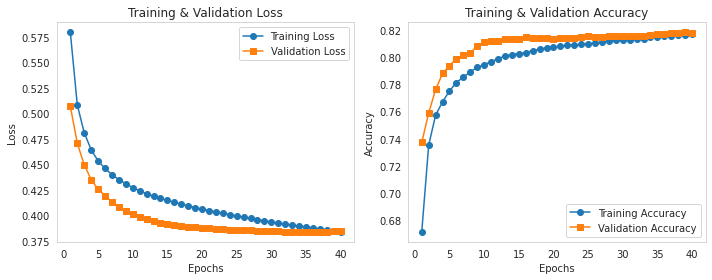

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  # First subplot
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2) 
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Training Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()